In [ ]:
# Suppression des avertissements
import warnings
warnings.simplefilter('ignore')


import itertools
import os

# Modules de base
import numpy as np
import pandas as pd  
import random
import joblib
from math import sqrt

# Visualisation
import matplotlib.pyplot as plt  

# Stats et analyses statistiques
import scipy.stats as stats  
from scipy.stats import randint, uniform
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Machine Learning et modèles de régression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from xgboost import XGBRegressor


from tabulate import tabulate


# Configuration du style de visualisation des graphiques avec un style personnalisé
plt.style.use("https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle")
# Configuration pour l'affichage des nombres à virgule flottante
pd.options.display.float_format = '{:.4f}'.format

In [ ]:
# Chargement des données
df_entrainement = pd.read_csv("../00 - Annexes/data_prepro/donnees_entrainement_prepro.csv")
df_validation = pd.read_csv("../00 - Annexes/data_prepro/donnees_validation_prepro.csv")

# Sélection des colonnes à supprimer
colonnes_a_supprimer = ['Prix', 'SKU', 'Timestamp', 'Annee', 'Mois', 'Jour', 'Heure', 
                        'Promotion', 'Categorie_Electronique', 'Categorie_Vetements', 'Categorie_Livres']
X = df_entrainement.drop(columns=colonnes_a_supprimer)
y = df_entrainement['Prix']

# Conservation des identifiants dans l'ensemble d'entraînement
train_identifiers = df_entrainement[['SKU', 'Timestamp']]

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

# Alignement des colonnes
if X_train.columns.tolist() != X_test.columns.tolist():
    X_test = X_test[X_train.columns]

# Initialisation et ajustement du scaler sur X_train
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Conservation des identifiants dans le jeu de validation
validation_identifiers = df_validation[['SKU', 'Timestamp']].reset_index(drop=True)

# Transformation du jeu de validation
X_validation = df_validation.drop(columns=colonnes_a_supprimer)
X_validation = X_validation[X_train.columns]
X_validation_scaled = scaler.transform(X_validation)
y_validation = df_validation['Prix'].values

# Création du DataFrame final en incluant les identifiants
validation_final = pd.DataFrame(X_validation_scaled, columns=X_train.columns)
validation_final['Prix'] = y_validation
validation_final['SKU'] = validation_identifiers['SKU']
validation_final['Timestamp'] = validation_identifiers['Timestamp']

# Réorganiser les colonnes si nécessaire
validation_final = validation_final[['SKU', 'Timestamp'] + list(X_train.columns) + ['Prix']]

# Sauvegarde du jeu de validation final
validation_final.to_csv("../00 - Annexes/data_prepro/donnees_validation_scaled.csv", index=False)


In [4]:
# Sauvegarde du scaler
joblib.dump(scaler, "../00 - Annexes/data_prepro/scaler.pkl")

['../00 - Annexes/data_prepro/scaler.pkl']

---------

----------------------------------


## 1. **Régression linéaire**

In [9]:
# Initialisation du modèle de Régression Linéaire
model_lr = LinearRegression()

# Entraînement du modèle
model_lr.fit(X_train_scaled, y_train)

# Prédictions sur l'ensemble de test
y_pred_lr = model_lr.predict(X_test_scaled)

# Évaluation des performances du modèle
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print('Métriques d\'évaluation de la Régression Linéaire :')
print(f'RMSE : {rmse_lr:.4f}')
print(f'MAE : {mae_lr:.4f}')
print(f'Coefficient de détermination R² : {r2_lr:.4f}')


Métriques d'évaluation de la Régression Linéaire :
RMSE : 22.7476
MAE : 18.7583
Coefficient de détermination R² : 0.9730


----------------------------

## 2. **Random Forest**

In [10]:
# Définition des distributions de paramètres pour la recherche
param_dist = {
    'n_estimators': randint(50, 300),  
    'max_features': ['sqrt', 'log2'],
    'max_depth': randint(5, 50),  
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False]
}

# Configuration de RandomizedSearchCV avec des paramètres optimisés
model_rf = RandomizedSearchCV(
    RandomForestRegressor(random_state=17),
    param_distributions=param_dist,
    n_iter=20,  # Réduction du nombre d'itérations
    cv=3,  # Utilisation de la validation croisée à 3 plis
    verbose=1,  
    n_jobs=-1,  
    random_state=17
)

# Entraînement du modèle
model_rf.fit(X_train_scaled, y_train)

# Prédictions sur l'ensemble de test
y_pred_rf = model_rf.predict(X_test_scaled)

# Évaluation des performances du modèle
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print('\nMétriques d\'évaluation pour la Régression par Forêt Aléatoire :')
print(f'RMSE : {rmse_rf:.4f}')
print(f'MAE : {mae_rf:.4f}')
print(f'Coefficient de détermination R² : {r2_rf:.4f}')


Fitting 3 folds for each of 20 candidates, totalling 60 fits

Métriques d'évaluation pour la Régression par Forêt Aléatoire :
RMSE : 1.9460
MAE : 0.9838
Coefficient de détermination R² : 0.9998


-----------------------------



## 3. **XGBoost**

In [11]:
# Définir la grille de recherche des hyperparamètres avec des plages optimisées
param_dist = {
    'n_estimators': randint(50, 300),  # Réduction de la plage pour alléger le calcul
    'learning_rate': uniform(0.01, 0.2),  # Plage ajustée pour une exploration ciblée
    'max_depth': randint(3, 7),  # Réduction de la profondeur maximale pour limiter la complexité
    'subsample': uniform(0.6, 0.4),  # Ajustement pour réduire la variance
    'colsample_bytree': uniform(0.6, 0.4),  # Plage réduite pour limiter la recherche
    'gamma': uniform(0, 0.3)  # Réduction de la plage pour une exploration plus ciblée
}

# Configurer RandomizedSearchCV avec des paramètres optimisés pour les performances
model_xgb = RandomizedSearchCV(
    XGBRegressor(objective='reg:squarederror', random_state=17),
    param_distributions=param_dist,
    n_iter=20,  # Réduction du nombre d'itérations
    cv=3,  # Utilisation de la validation croisée à 3 plis
    verbose=1,  # Verbose réduit pour des informations modérées
    n_jobs=-1,  # Utilisation de tous les cœurs disponibles pour accélérer
    random_state=17
)

# Entraîner le modèle
model_xgb.fit(X_train_scaled, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred_xgb = model_xgb.predict(X_test_scaled)

# Évaluer les performances du modèle
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print('\nMétriques d\'évaluation pour la régression XGBoost :')
print(f'RMSE : {rmse_xgb:.4f}')
print(f'MAE : {mae_xgb:.4f}')
print(f'Coefficient de détermination R² : {r2_xgb:.4f}')


Fitting 3 folds for each of 20 candidates, totalling 60 fits

Métriques d'évaluation pour la régression XGBoost :
RMSE : 1.0000
MAE : 0.6827
Coefficient de détermination R² : 0.9999


--------------------------

## 4. **Ridge Regression**

In [12]:
# Initialisation du modèle de régression Ridge
model_ridge = Ridge(
    alpha=1.0,          
    random_state=17
)

# Entraînement du modèle
model_ridge.fit(X_train_scaled, y_train)

# Prédictions sur l'ensemble de test
y_pred_ridge = model_ridge.predict(X_test_scaled)

# Évaluation des performances du modèle
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print('\nMétriques d\'évaluation pour la régression Ridge :')
print(f'RMSE : {rmse_ridge:.4f}')
print(f'MAE : {mae_ridge:.4f}')
print(f'Coefficient de détermination R² : {r2_ridge:.4f}')



Métriques d'évaluation pour la régression Ridge :
RMSE : 22.7477
MAE : 18.7585
Coefficient de détermination R² : 0.9730


----------------------------

## 5. **Lasso Regression**

In [13]:
# Initialisation du modèle de régression Lasso
model_lasso = Lasso(
    alpha=0.01,         
    random_state=17
)

# Entraînement du modèle
model_lasso.fit(X_train_scaled, y_train)

# Prédictions sur l'ensemble de test
y_pred_lasso = model_lasso.predict(X_test_scaled)

# Évaluation des performances du modèle
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print('\nMétriques d\'évaluation pour la régression Lasso :')
print(f'RMSE : {rmse_lasso:.4f}')
print(f'MAE : {mae_lasso:.4f}')
print(f'Coefficient de détermination R² : {r2_lasso:.4f}')



Métriques d'évaluation pour la régression Lasso :
RMSE : 22.7474
MAE : 18.7581
Coefficient de détermination R² : 0.9730


------------------------

## 6. **Decision Tree**

In [14]:
# Définition des paramètres optimisés pour GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],  # Réduction des valeurs testées
    'min_samples_split': [2, 5],  # Réduction du nombre de valeurs testées
    'min_samples_leaf': [1, 2]  # Réduction du nombre de valeurs testées
}

# Configuration de GridSearchCV avec une validation croisée à 3 plis
model_dt = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,  # Réduction à 3 plis pour diminuer la charge de calcul
    n_jobs=-1,  # Utilisation de tous les cœurs disponibles pour accélérer
    verbose=2
)

# Entraînement du modèle
model_dt.fit(X_train_scaled, y_train)

# Prédictions sur l'ensemble de test
y_pred_dt = model_dt.predict(X_test_scaled)

# Évaluation des performances du modèle
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print('\nMétriques d\'évaluation pour la régression par arbre de décision :')
print(f'RMSE : {rmse_dt:.4f}')
print(f'MAE : {mae_dt:.4f}')
print(f'Coefficient de détermination R² : {r2_dt:.4f}')


Fitting 3 folds for each of 12 candidates, totalling 36 fits

Métriques d'évaluation pour la régression par arbre de décision :
RMSE : 7.7922
MAE : 4.2316
Coefficient de détermination R² : 0.9968


---------------------------

## 7. **SARIMAX**

-----------------------------------

In [22]:
# Chargement des données
df_entrainement = pd.read_csv("../00 - Annexes/data_prepro/donnees_entrainement_prepro.csv")

# Préparation des données avec variables exogènes
df_entrainement['Timestamp'] = pd.to_datetime(df_entrainement['Timestamp'])
df_ts = df_entrainement[['Timestamp', 'Prix', 'PrixInitial', 'AgeProduitEnJours', 'QuantiteVendue', 'UtiliteProduit', 'ElasticitePrix',
                         'Remise', 'Qualite', 'Categorie_Electronique', 'Categorie_Livres',
                         'Categorie_Vetements']].copy()
df_ts.set_index('Timestamp', inplace=True)

# Agrégation quotidienne
df_ts = df_ts.resample('D').mean()

# Gestion des valeurs manquantes
df_ts.interpolate(method='linear', inplace=True)


In [23]:

# Vérification de la stationnarité de la cible
adf_result = adfuller(df_ts['Prix'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

# Différenciation conditionnelle
if adf_result[1] > 0.05:
    df_ts['Prix_diff'] = df_ts['Prix'].diff().dropna()
    y_train_ts = df_ts['Prix_diff']
    exog = df_ts.drop(columns=['Prix', 'Prix_diff']).diff().dropna()
else:
    y_train_ts = df_ts['Prix']
    exog = df_ts.drop(columns=['Prix'])


ADF Statistic: -8.553257430589484
p-value: 9.102091415890685e-14


In [24]:
# Identifier et exclure les variables constantes avant différenciation
variables_to_exclude = ['PrixInitial', 'Qualite', 'Categorie_Electronique', 'Categorie_Livres', 'Categorie_Vetements', 'Promotion']
exog = exog.drop(columns=variables_to_exclude, errors='ignore')

# Appliquer une différenciation pour rendre les variables non stationnaires stationnaires
non_stationary_vars = ['AgeProduitEnJours', 'QuantiteVendue', 'UtiliteProduit']
exog[non_stationary_vars] = exog[non_stationary_vars].diff().dropna()

# Vérification des colonnes constantes après transformation
constant_columns = [col for col in exog.columns if exog[col].nunique() <= 1]
if constant_columns:
    print(f"Colonnes constantes après transformation : {constant_columns}")
    exog = exog.drop(columns=constant_columns)

# Vérification de la stationnarité après transformation
for column in non_stationary_vars:
    if column in exog.columns:  # Vérifier que la colonne existe après suppression des constantes
        adf_test = adfuller(exog[column].dropna())
        print(f"ADF Statistic for {column} after transformation: {adf_test[0]}, p-value: {adf_test[1]}")


Colonnes constantes après transformation : ['AgeProduitEnJours']
ADF Statistic for QuantiteVendue after transformation: -11.424816226112759, p-value: 6.735688226714772e-21
ADF Statistic for UtiliteProduit after transformation: -11.325596027819932, p-value: 1.1456120700562041e-20


In [25]:
# Nettoyage automatique des colonnes constantes
exog = exog.loc[:, exog.nunique() > 1]

# Différenciation des exogènes uniquement si nécessaire
if adf_result[1] > 0.05:
    exog_diff = exog.diff().dropna()
    if not exog_diff.isnull().any().any():
        exog = exog_diff

# Suppression des valeurs NaN et réalignement
exog.replace([np.inf, -np.inf], np.nan, inplace=True)
exog.dropna(inplace=True)
y_train_ts = y_train_ts.loc[exog.index]

# Vérification des dimensions
if len(exog) != len(y_train_ts):
    raise ValueError("Mismatch between exog and target length!")

In [26]:
# Division en ensembles d'entraînement et de test (respect des dépendances temporelles)
# Nettoyage des exogènes
exog.replace([np.inf, -np.inf], np.nan, inplace=True)  # Remplacer Inf par NaN
exog.dropna(inplace=True)  # Supprimer les lignes contenant des NaN

train_size = int(len(y_train_ts) * 0.8)
train_data, test_data = y_train_ts.iloc[:train_size], y_train_ts.iloc[train_size:]
exog_train, exog_test = exog.iloc[:train_size], exog.iloc[train_size:]

In [27]:

# Réaligner la cible avec les exogènes nettoyées
y_train_ts = y_train_ts.loc[exog.index]

# Vérifications pour assurer l'intégrité des données
if exog.isnull().any().any():
    raise ValueError("exog contains NaN values even after cleaning!")
if len(exog) != len(y_train_ts):
    raise ValueError("Mismatch between exog and target length!")

p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = 7

# Recherche des meilleurs paramètres SARIMAX
best_aic = np.inf
for param in itertools.product(p, d, q):
    for seasonal_param in itertools.product(P, D, Q, [s]):
        try:
            mod = SARIMAX(
                train_data,
                exog=exog_train,
                order=param,
                seasonal_order=seasonal_param,
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            results = mod.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = seasonal_param
        except Exception as e:
            print(f"Erreur avec les paramètres {param} et {seasonal_param}: {e}")

print(f'Best SARIMAX order: {best_order}, Seasonal order: {best_seasonal_order}, AIC: {best_aic}')


c:\Users\samir\anaconda3\envs\envsynth\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\samir\anaconda3\envs\envsynth\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\samir\anaconda3\envs\envsynth\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\samir\anaconda3\envs\envsynth\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\samir\anaconda3\envs\envsynth\lib\s

Best SARIMAX order: (1, 1, 2), Seasonal order: (1, 0, 0, 7), AIC: 82.80633920781536


c:\Users\samir\anaconda3\envs\envsynth\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


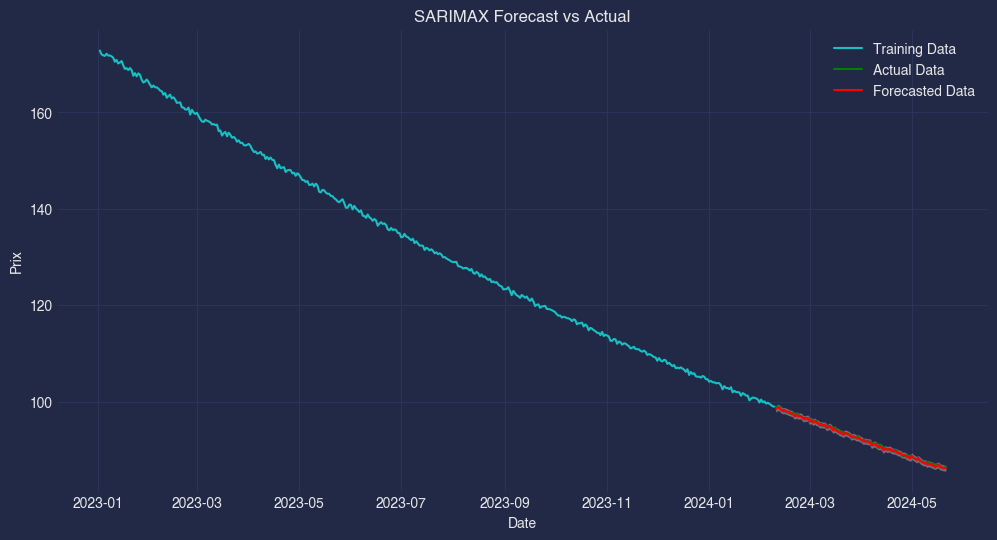

In [28]:
# Entraînement final
model = SARIMAX(
    train_data,
    exog=exog_train,
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
)
model_fit = model.fit(disp=False)

# Visualisation des prédictions
forecast = model_fit.get_forecast(steps=len(test_data), exog=exog_test)
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Data', color='green')
plt.plot(forecast_values.index, forecast_values, label='Forecasted Data', color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMAX Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Prix')
plt.legend()
plt.show()


In [29]:
mse_sarimax = mean_squared_error(test_data, forecast_values)
mae_sarimax = mean_absolute_error(test_data, forecast_values)
rmse_sarimax = np.sqrt(mse_sarimax)

-------------------------

In [30]:
# Compilation des métriques dans un DataFrame
metrics = pd.DataFrame({
    'Modèle': [
        'Régression Linéaire', 'Random Forest', 'XGBoost', 
        'Ridge', 'Lasso', 'Decision Tree', 'SARIMAX'
    ],
    'RMSE': [rmse_lr, rmse_rf, rmse_xgb, rmse_ridge, rmse_lasso, rmse_dt, rmse_sarimax],
    'MAE': [mae_lr, mae_rf, mae_xgb, mae_ridge, mae_lasso, mae_dt, mae_sarimax],
    'R² Score': [r2_lr, r2_rf, r2_xgb, r2_ridge, r2_lasso, r2_dt, None]  # Si indisponible, mettre None
})

# Affichage du tableau avec tabulate
print("\nTableau récapitulatif des métriques pour tous les modèles :")
print(tabulate(metrics, headers='keys', tablefmt='pretty', showindex=False))



Tableau récapitulatif des métriques pour tous les modèles :
+---------------------+---------------------+---------------------+--------------------+
|       Modèle        |        RMSE         |         MAE         |      R² Score      |
+---------------------+---------------------+---------------------+--------------------+
| Régression Linéaire | 22.747646109824945  | 18.758346164221564  | 0.9730208558778745 |
|    Random Forest    | 1.9460263009998116  | 0.9838164675573485  | 0.9998025520391866 |
|       XGBoost       | 0.9999591583518458  | 0.6826957043859587  | 0.9999478661538033 |
|        Ridge        | 22.747661705801818  |  18.75848450574891  | 0.973020818883607  |
|        Lasso        | 22.747371925371453  | 18.758126945179395  | 0.9730215062499851 |
|    Decision Tree    |  7.792190368072995  | 4.2316017563001695  | 0.9968342665154001 |
|       SARIMAX       | 0.20760787754004154 | 0.16345168773898144 |        nan         |
+---------------------+---------------------+----

In [ ]:
if not os.path.exists('../00 - Annexes/models'):
    os.makedirs('../00 - Annexes/models')
    
directory = "../00 - Annexes/models/"


# Sérialisation des modèles non compatibles avec le format HDF5 au format Pickle
joblib.dump(model_lr, directory + 'model_lr.pkl')
joblib.dump(model_rf, directory + 'model_rf.pkl')
joblib.dump(model_xgb, directory + 'model_xgb.pkl')
joblib.dump(model_ridge, directory + 'model_ridge.pkl')
joblib.dump(model_lasso, directory + 'model_lasso.pkl')
joblib.dump(model_dt, directory + 'model_dt.pkl')
joblib.dump(model_fit, directory + 'model_sarimax.pkl') 

metrics.to_csv('../00 - Annexes/data_prepro/metrics_train.csv', index=False)